# Simple linear model

Try and train a simple linear model for one center, for one forecast date, for one lead time.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask
import dask.array as da
import dask.distributed
import dask_jobqueue
import pathlib
import xarray as xr

In [3]:
INPUT_TRAIN = '***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf'
input_path = pathlib.Path(INPUT_TRAIN)

In [4]:
OUTPUT_TRAIN = '***HOME***hdd_scratch/s2s/training-output-benchmark/'

In [102]:
REFERENCE_TRAIN = '***HOME***hdd_scratch/s2s/training-output-reference/'

## Boot Dask cluster

In [5]:
cluster = dask_jobqueue.SLURMCluster(
    env_extra=['source ***HOME***.bash_profile','conda activate s2s'],
)

***REMOVED***/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43212 instead
  warnings.warn(


In [6]:
cluster.scale(jobs=2)  # Scale to two working nodes as configured.
client = dask.distributed.Client(cluster)

In [8]:
client

Client Scheduler: tcp://10.20.40.85:36739 Dashboard: http://10.20.40.85:43212/status,Cluster Workers: 16 Cores: 16 Memory: 186.24 GiB


## Read input data

In [15]:
CENTER = 'eccc'
DATE = '20200102'

In [16]:
files = [f for f in input_path.iterdir() if CENTER in f.stem if DATE in f.stem]

In [17]:
files

[PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-tcw-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-rsn-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-msl-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-sp-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-t2m-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-q-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-gh-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-u-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-v-20200102.nc'),
 PosixPath('***HOME***hdd_scratch/s2s/training-input/0.3.0/netcdf/eccc-hindcast-ci-20200102.nc'),
 PosixPath('***HOME

In [18]:
datasets = []
for f in files:
    datasets.append(xr.load_dataset(f))

In [19]:
datasets[0]

<xarray.Dataset>
Dimensions:           (entireAtmosphere: 1, forecast_time: 20, latitude: 121, lead_time: 32, longitude: 240, realization: 4)
Coordinates:
  * realization       (realization) int64 0 1 2 3
  * forecast_time     (forecast_time) datetime64[ns] 1998-01-02 ... 2017-01-02
  * lead_time         (lead_time) timedelta64[ns] 1 days 2 days ... 32 days
  * entireAtmosphere  (entireAtmosphere) float64 0.0
  * latitude          (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude         (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time        (forecast_time, lead_time) datetime64[ns] 1998-01-03 .....
Data variables:
    tcw               (realization, forecast_time, lead_time, entireAtmosphere, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-05-11T09:34 GRIB to CDM+CF via cfgrib-0.9.9...

In [43]:
'entireAtmosphere' in datasets[0].coords

True

In [44]:
dataset_with_level = []
dataset_wo_level = []

for d in datasets:
    if 'plev' in d.coords:
        dataset_with_level.append(d)
    else:
        dataset_wo_level.append(d)

In [51]:
dataset_wo_level[0]

<xarray.Dataset>
Dimensions:           (entireAtmosphere: 1, forecast_time: 20, latitude: 121, lead_time: 32, longitude: 240, realization: 4)
Coordinates:
  * realization       (realization) int64 0 1 2 3
  * forecast_time     (forecast_time) datetime64[ns] 1998-01-02 ... 2017-01-02
  * lead_time         (lead_time) timedelta64[ns] 1 days 2 days ... 32 days
  * entireAtmosphere  (entireAtmosphere) float64 0.0
  * latitude          (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude         (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time        (forecast_time, lead_time) datetime64[ns] 1998-01-03 .....
Data variables:
    tcw               (realization, forecast_time, lead_time, entireAtmosphere, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-05-11T09:34 GRIB to CDM+CF via cfgrib-0.9.9...

In [52]:
full_dataset = xr.merge(dataset_wo_level)

In [54]:
full_dataset

<xarray.Dataset>
Dimensions:           (entireAtmosphere: 1, forecast_time: 20, latitude: 121, lead_time: 32, longitude: 240, meanSea: 1, nominal_top: 1, realization: 4)
Coordinates:
  * realization       (realization) int64 0 1 2 3
  * forecast_time     (forecast_time) datetime64[ns] 1998-01-02 ... 2017-01-02
  * lead_time         (lead_time) timedelta64[ns] 1 days 2 days ... 32 days
  * entireAtmosphere  (entireAtmosphere) float64 0.0
  * latitude          (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude         (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time        (forecast_time, lead_time) datetime64[ns] 1998-01-03 .....
  * meanSea           (meanSea) float64 0.0
  * nominal_top       (nominal_top) float64 0.0
Data variables:
    tcw               (realization, forecast_time, lead_time, entireAtmosphere, latitude, longitude) float32 ...
    rsn               (realization, forecast_time, lead_time, latitude, longitude) float32 ...
    msl               (realization, forecast_time, lead_time, meanSea, latitude, longitude) float32 ...
    sp                (realization, forecast_time, lead_time, latitude, longitude) float32 ...
    t2m               (realization, forecast_time, lead_time, latitude, longitude) float32 ...
    siconc            (realization, forecast_time, lead_time, latitude, longitude) float32 ...
    tcc               (realization, forecast_time, lead_time, entireAtmosphere, latitude, longitude) float32 ...
    lsm               (realization, forecast_time, lead_time, latitude, longitude) float32 ...
    ttr               (realization, forecast_time, lead_time, nominal_top, latitude, longitude) float32 ...
    sst               (realization, forecast_time, lead_time, latitude, longitude) float32 ...
    tp                (realization, forecast_time, lead_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-05-11T09:34 GRIB to CDM+CF via cfgrib-0.9.9...

In [61]:
one_lead_time = full_dataset.isel(lead_time=21, meanSea=0, entireAtmosphere=0, nominal_top=0).drop(['rsn', 'siconc', 'lsm', 'sst', 'tp'])

In [62]:
one_lead_time

<xarray.Dataset>
Dimensions:           (forecast_time: 20, latitude: 121, longitude: 240, realization: 4)
Coordinates:
  * realization       (realization) int64 0 1 2 3
  * forecast_time     (forecast_time) datetime64[ns] 1998-01-02 ... 2017-01-02
    lead_time         timedelta64[ns] 22 days
    entireAtmosphere  float64 0.0
  * latitude          (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude         (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time        (forecast_time) datetime64[ns] 1998-01-24 ... 2017-01-24
    meanSea           float64 0.0
    nominal_top       float64 0.0
Data variables:
    tcw               (realization, forecast_time, latitude, longitude) float32 ...
    msl               (realization, forecast_time, latitude, longitude) float32 ...
    sp                (realization, forecast_time, latitude, longitude) float32 ...
    t2m               (realization, forecast_time, latitude, longitude) float32 ...
    tcc               (realization, forecast_time, latitude, longitude) float32 ...
    ttr               (realization, forecast_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-05-11T09:34 GRIB to CDM+CF via cfgrib-0.9.9...

In [63]:
one_lead_time.isnull().sum()

<xarray.Dataset>
Dimensions:           ()
Coordinates:
    lead_time         timedelta64[ns] 22 days
    entireAtmosphere  float64 0.0
    meanSea           float64 0.0
    nominal_top       float64 0.0
Data variables:
    tcw               int64 0
    msl               int64 0
    sp                int64 0
    t2m               int64 0
    tcc               int64 0
    ttr               int64 0

In [69]:
one_lead_time.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [70]:
np_input = one_lead_time.to_array(dim='field').transpose('forecast_time', 'latitude', 'longitude', 'field', 'realization').data

In [73]:
np_input = np_input.reshape(20, 121, 240, -1)

In [74]:
np_input.shape

(20, 121, 240, 24)

## Reading output values

In [75]:
!ls {OUTPUT_TRAIN}

t2m.nc	t2m-weeks-34.nc  t2m-weeks-56.nc  tp.nc  tp-weeks-34.nc  tp-weeks-56.nc


In [76]:
t2m = xr.open_dataset(OUTPUT_TRAIN + '/t2m.nc')

In [77]:
t2m

<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 1079, latitude: 121, lead_time: 2, longitude: 240)
Coordinates:
  * category       (category) object 'below normal' 'near normal' 'above normal'
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-12-31
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time, lead_time) datetime64[ns] ...
Data variables:
    t2m            (category, forecast_time, lead_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-06-04T12:31 GRIB to CDM+CF via cfgrib-0.9.9...
    comment_lead_time:       The value of valid_time does not refer to the da...

In [90]:
first_forecast_t2m = t2m.sel(forecast_time=t2m.forecast_time.dt.day == 2).isel(lead_time=0)

In [91]:
first_forecast_t2m

<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 60, latitude: 121, longitude: 240)
Coordinates:
  * category       (category) object 'below normal' 'near normal' 'above normal'
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-07-02
    lead_time      timedelta64[ns] 14 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time) datetime64[ns] 2000-01-16 ... 2019-07-16
Data variables:
    t2m            (category, forecast_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-06-04T12:31 GRIB to CDM+CF via cfgrib-0.9.9...
    comment_lead_time:       The value of valid_time does not refer to the da...

In [89]:
t2m.lead_time.data.astype('timedelta64[D]')

array([14, 28], dtype='timedelta64[D]')

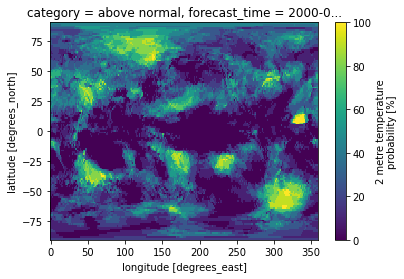

In [98]:
first_forecast_t2m.isel(category=2, forecast_time=20).t2m.plot()

## Check one of the bi-weekly files

In [100]:
t2m_weekly = xr.open_dataset(OUTPUT_TRAIN + '/t2m-weeks-34.nc')

In [101]:
t2m_weekly

<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 1079, latitude: 121, lead_time: 1, longitude: 240)
Coordinates:
  * category       (category) object 'below normal' 'near normal' 'above normal'
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-12-31
  * lead_time      (lead_time) timedelta64[ns] 14 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time, lead_time) datetime64[ns] ...
Data variables:
    t2m            (category, forecast_time, lead_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-06-04T12:31 GRIB to CDM+CF via cfgrib-0.9.9...
    comment_lead_time:       The value of valid_time does not refer to the da...

## Check the other type of forecast

In [105]:
reference_t2m = xr.open_dataset(REFERENCE_TRAIN + '/t2m-20200102.nc')

In [106]:
reference_t2m

<xarray.Dataset>
Dimensions:        (forecast_time: 20, latitude: 121, lead_time: 47, longitude: 240)
Coordinates:
    valid_time     (lead_time, forecast_time) datetime64[ns] ...
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-01-02
  * lead_time      (lead_time) timedelta64[ns] 0 days 1 days ... 45 days 46 days
Data variables:
    t2m            (lead_time, forecast_time, latitude, longitude) float32 ...
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

In [107]:
reference_t2m.lead_time.data.astype('timedelta64[D]')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46],
      dtype='timedelta64[D]')